# Streamageddon
Spotify's armageddon investments and data science meet
## Preprocessing (positive dataset)

In [82]:
%pip install --quiet pandas==2.3.2 wordcloud==1.9.4

Note: you may need to restart the kernel to use updated packages.


In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud

df_positive = pd.read_csv("artists_positive.csv")
df_negative = pd.read_csv("artists_negative.csv")
df_json = pd.read_json("spotify-artists.json")
df_json_normalized = pd.json_normalize(df_json["artists"])

id = df_json_normalized["id"]
genres = df_json_normalized["genres"]
followers_total = df_json_normalized["followers.total"]
popularity = df_json_normalized["popularity"]
name = df_json_normalized["name"]
# First image of an artist
image = df_json_normalized["images"][0][0]["url"]
data = {"SpotifyId": id,
        "Genres": genres,
        "Followers": followers_total,
        "Popularity": popularity,
        "Image": image}

df_json_final = pd.DataFrame(data)
df = df_json_final.merge(df_positive, on="SpotifyId", how="inner")
df["Date"] = pd.to_datetime(df["Date"], format="%Y%m%d")

## Preprocessing (negative dataset)

In [84]:
# Remove unneccesary columns
df_negative = df_negative.drop(columns=["first_release", "last_release", "num_releases", "num_tracks", "monthly_listeners"])

# Rename columns for uniformity
df_negative = df_negative.rename(columns={
    "ids": "SpotifyId",
    "names": "Name",
    "popularity": "Popularity",
    "followers": "Followers",
    "genres": "Genres"
})

In [85]:
# Convert genres to lists
for i in range(df_negative.shape[0]):
    genres = df_negative.at[i, "Genres"]
    genres_list = genres.split(", ")

    # Remove whitespaces
    for j in range(len(genres_list)):
        genres_list[j] = genres_list[j].strip()
    df_negative.at[i, "Genres"] = genres_list
    
print(df_negative)

                    SpotifyId             Name  Popularity  Followers  \
0      2P3aLwJ41aRYkyFFw2FRM7   sam concepcion          45     168497   
1      2FCVB3cfCC0e3O8G7Gs8t6     bleib modern          28      23349   
2      3ZaPFQ05J5qSM5I3Smbp44           tevvez          58     259154   
3      71WUmUmWWaqqGtVP8MlPJb    semi.official           4       1050   
4      0MVM5Khj39EkpVtLvU9Ujp         ovsicori           4        316   
...                       ...              ...         ...        ...   
15022  2yKHbwUwzWkBhv4LQovsID  silence the foe           0        155   
15023  6CASjxvuwzyyL0rnFWqrnU     low millions           9       1464   
15024  3uiPLpsoKPaPXAU3qWe6w8     tori letzler          17       1092   
15025  5dHTM4YeTjVYynek31IhKM          zartako          16       4656   
15026  5to1zJGYOE6mJMOxACZRJR     zeus b. held           4        480   

                                      Genres  
0                                      [opm]  
1              [dark post-pun

## Genre transformation

In [86]:
general_genres = ["metal", "rock", "pop", "jazz", "reggae", "blues", "electro", "folk", "punk", 
                 "hardcore", "grunge", "classical", "country", "house", "techno", "trance", "ambient", "noise",
                 "shoegaze", "lo-fi", "contemporary", "acoustic", "instrumental", "world", "disco", "synth", "drone", 
                 "singer-songwriter", "drum and bass", "r&b", "garage", "downtempo", "orchestra",
                 "modern", "dance", "dubstep", "choir", "opera", "renaissance", "latin", "grind", "soundtrack",
                 "gospel", "flamenco", "baroque", "traditional", "chanson", "christian", "thrash", "prog",
                 "indie", "alternative", "experimental", "soul", "goth", "hardstyle", "psych", "funk", "wave",
                 "edm", "idm", "eurobeat", "emo", "trip hop", "avantgarde", "abstract", "groove", "breakbeat", "chill",
                 "deathcore", "americana", "romantic", "industrial", "salsa", "piano", "glitch", "violin", "comedy",
                 "rave", "doom", "tango", "lounge", "step", "guitar"
                ]

def transform_genres(df):
    for i in range(df.shape[0]):
        genres_list = df.at[i, "Genres"]
        
        for j in range(len(genres_list)):
            if ("rap" in genres_list[j]) or ("hip hop" in genres_list[j]) or ("hip-hop" in genres_list[j]):
                genres_list[j] = "hip hop/rap"
            elif "dnb" in genres_list[j]:
                genres_list[j] = "drum and bass"
            elif "choral" in genres_list[j]:
                genres_list[j] = "choir"
            else:
                for g in general_genres:
                    if g in genres_list[j]:
                        genres_list[j] = g
                        break
        genres_list = list(set(genres_list))
        df.at[i, "Genres"] = genres_list

In [87]:
transform_genres(df)
transform_genres(df_negative)
print(df)

                  SpotifyId                     Genres  Followers  Popularity  \
0    6XYvaoDGE0VmRt83Jss9Sn              [psych, rock]    1316858          49   
1    5DDuwU1X2Aqdp3CxfXstRe                    [lo-fi]      27499          33   
2    7AZwAitWq1KcFoIJhRWb6V                     [rock]     122693          29   
3    5JLqvjW3Nyom2OsRUyFsS9  [experimental, rock, pop]     188888          34   
4    1kpDT6GWeimdyCmkwvTPvt   [house, electro, techno]       1987           7   
..                      ...                        ...        ...         ...   
99   1vyS5XhaZ09NckqPc9ZrD1        [alternative, rock]         56           0   
100  0AWoGmyIhqmbAjB4vnSmvQ              [hip hop/rap]        172           0   
101  6FXMGgJwohJLUSr5nVlf9X      [trip hop, downtempo]    2620607          72   
102  48EurMIjEUuRpNFLbkSiwa          [pop, folk, rock]         22           0   
103  5ClX8NZncckoDDV5FgKFvd  [alternative, folk, rock]         47           0   

                           

## Exploratory data analysis (positive dataset)

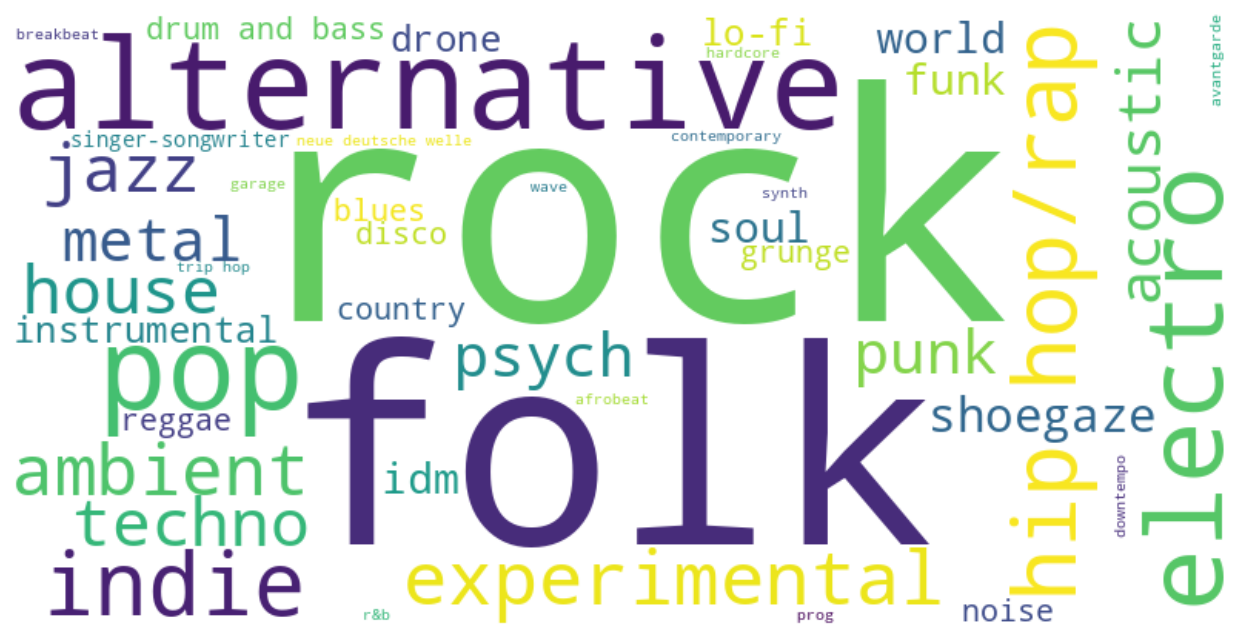

In [88]:
flat_genres = df.explode("Genres")

unique, counts = np.unique(flat_genres["Genres"], return_counts=True)

genres_dict = {}
for i in range(len(unique)):
    genres_dict[unique[i]] = counts[i]

wc = WordCloud(width=800, height=400, background_color="white")

wc.generate_from_frequencies(genres_dict)

plt.figure(figsize=(16, 8))
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

         Genres  Count
0          rock     34
1          folk     24
2   alternative     20
3           pop     16
4       electro     14
5   hip hop/rap      9
6         indie      9
7  experimental      8
8       ambient      7
9         house      6


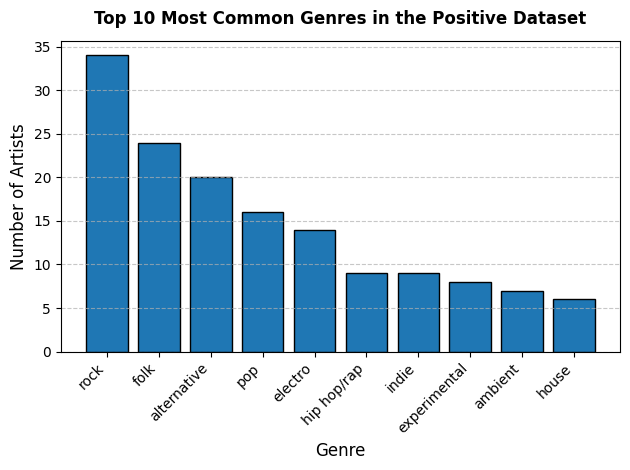

In [89]:
topten = sorted(genres_dict, key=genres_dict.get, reverse=True)[:10]
counts2 = np.asarray(sorted(counts, reverse=True)[:10])
topten_df = pd.DataFrame({"Genres": topten, "Count": counts2.astype(int)})
print(topten_df)

plt.bar(topten_df["Genres"], topten_df["Count"], edgecolor="black")
plt.xlabel("Genre", fontsize=12)
plt.ylabel("Number of Artists", fontsize=12)
plt.xticks(rotation=45, horizontalalignment="right", fontsize=10)
plt.yticks(fontsize=10)
plt.title("Top 10 Most Common Genres in the Positive Dataset", fontsize=12, weight="bold", pad=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

In [90]:
avg_popularity = df["Popularity"].mean()
avg_followers = df["Followers"].mean()

print(f"Mean popularity: {avg_popularity}")
print(f"Mean followers: {avg_followers}")

med_popularity = df["Popularity"].median()
med_followers = df["Followers"].median()

print(f"Median popularity: {med_popularity}")
print(f"Median followers: {med_followers}")

Mean popularity: 10.038461538461538
Mean followers: 67606.09615384616
Median popularity: 1.0
Median followers: 550.0


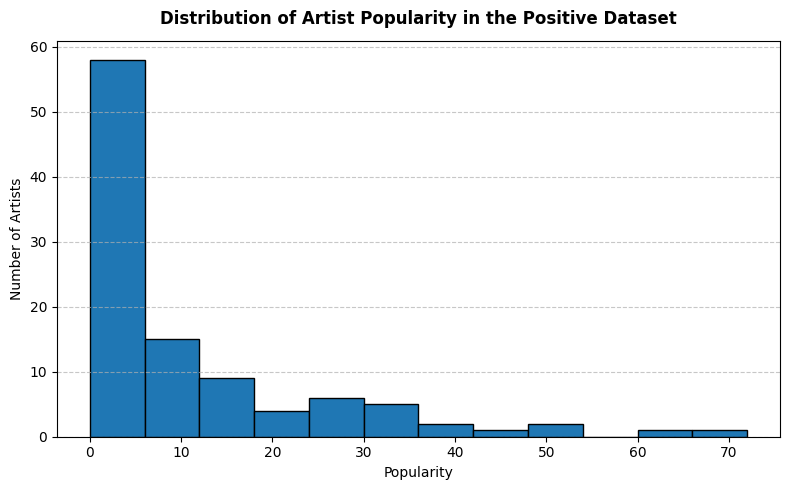

In [91]:
plt.figure(figsize=(8,5))
plt.hist(df["Popularity"], bins=12, edgecolor="black")
plt.xlabel("Popularity")
plt.ylabel("Number of Artists")
plt.title("Distribution of Artist Popularity in the Positive Dataset", fontsize=12, weight="bold", pad=12)
plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

## Exploratory data analysis (negative dataset)

        Genres  Count
0          pop   2121
1         rock   2112
2        metal   1321
3        indie   1236
4  hip hop/rap   1126
5         jazz    823
6         punk    703
7        house    605
8    classical    603
9         folk    539


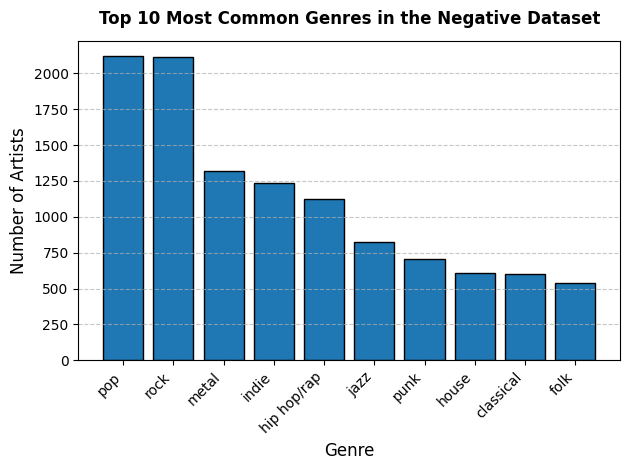

In [92]:
flat_genres = df_negative.explode("Genres")

unique, counts = np.unique(flat_genres["Genres"], return_counts=True)

genres_dict = {}
for i in range(len(unique)):
    genres_dict[unique[i]] = counts[i]
    
topten_neg = sorted(genres_dict, key=genres_dict.get, reverse=True)[:10]
counts2 = np.asarray(sorted(counts, reverse=True)[:10])
topten_df_neg = pd.DataFrame({"Genres": topten_neg, "Count": counts2.astype(int)})
print(topten_df_neg)

plt.bar(topten_df_neg["Genres"], topten_df_neg["Count"], edgecolor="black")
plt.xlabel("Genre", fontsize=12)
plt.ylabel("Number of Artists", fontsize=12)
plt.xticks(rotation=45, horizontalalignment="right", fontsize=10)
plt.yticks(fontsize=10)
plt.title("Top 10 Most Common Genres in the Negative Dataset", fontsize=12, weight="bold", pad=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

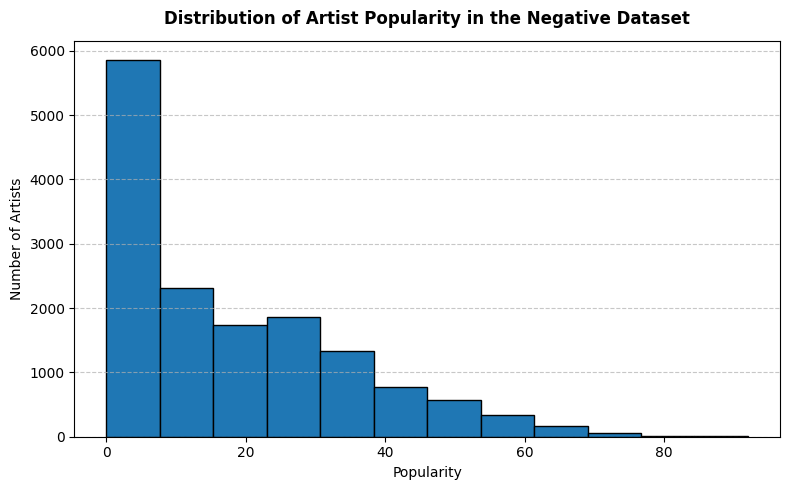

In [93]:
plt.figure(figsize=(8,5))
plt.hist(df_negative["Popularity"], bins=12, edgecolor="black")
plt.xlabel("Popularity")
plt.ylabel("Number of Artists")
plt.title("Distribution of Artist Popularity in the Negative Dataset", fontsize=12, weight="bold", pad=12)
plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

## Preprocessing for Machine Learning

In [94]:
"""Positive dataframe with other genres"""
"""

# Removes unnecessary columns from the original dataframe if they exist
def drop_columns(df, columns):
    if set(columns).issubset(df.columns):
        df.drop(columns=columns, inplace=True)

# Returns second dataframe where genres are a binary variable
# genres_list is a list with genre names to include minus "other"
def genres_as_columns(df, genres_list):
    df2 = df.copy()
    
    zeros = np.zeros(df2.shape[0])
    genres_list2 = genres_list + ["other"]

    for genre in (genres_list2):
        df2[genre] = zeros

    for i in range(df2.shape[0]):
        for genre in df2.at[i, "Genres"]:
            if genre in genres_list2:
                df2.at[i, genre] = 1.0
    
    df2.drop(columns=["Genres"], inplace=True)
    return df2

df2_positive = convert_genres(df, topten)

# Remove unneccesary columns
drop_columns(df2_positive, ["SpotifyId", "Image", "Name", "Date"])

df2_positive = genres_as_columns(df2_positive, topten)
df2_positive.insert(loc=0, column="left", value=np.ones(df2_positive.shape[0]))

print(df2_positive)
"""

'\n\n# Removes unnecessary columns from the original dataframe if they exist\ndef drop_columns(df, columns):\n    if set(columns).issubset(df.columns):\n        df.drop(columns=columns, inplace=True)\n\n# Returns second dataframe where genres are a binary variable\n# genres_list is a list with genre names to include minus "other"\ndef genres_as_columns(df, genres_list):\n    df2 = df.copy()\n\n    zeros = np.zeros(df2.shape[0])\n    genres_list2 = genres_list + ["other"]\n\n    for genre in (genres_list2):\n        df2[genre] = zeros\n\n    for i in range(df2.shape[0]):\n        for genre in df2.at[i, "Genres"]:\n            if genre in genres_list2:\n                df2.at[i, genre] = 1.0\n\n    df2.drop(columns=["Genres"], inplace=True)\n    return df2\n\ndf2_positive = convert_genres(df, topten)\n\n# Remove unneccesary columns\ndrop_columns(df2_positive, ["SpotifyId", "Image", "Name", "Date"])\n\ndf2_positive = genres_as_columns(df2_positive, topten)\ndf2_positive.insert(loc=0, colu

In [95]:
"""Positive dataframe with all genres"""

# Returns second dataframe where unpopular genres are converted to "other"
def convert_genres(df, genres_list):
    df2 = df.copy()
    for i in range(df2.shape[0]):
        for j in range(len(df2.at[i, "Genres"])):
            genre = df2.at[i, "Genres"][j]
            if genre not in genres_list:
                #print(genre)
                df2.at[i, "Genres"][j] = "other"
        df2.at[i, "Genres"] = list(set(df2.at[i, "Genres"]))
    return df2

# Removes unnecessary columns from the original dataframe if they exist
def drop_columns(df, columns):
    if set(columns).issubset(df.columns):
        df.drop(columns=columns, inplace=True)

def genres_as_columns_all(df):
    df2 = df.copy()

    all_genres = sorted(set(g for lst in df2["Genres"] for g in lst))
    zeros = np.zeros((df2.shape[0], len(all_genres)))
    genre_df = pd.DataFrame(zeros, columns=all_genres, index=df2.index)
    
    for i, genres in enumerate(df2["Genres"]):
        genre_df.loc[i, genres] = 1.0
        
    df2 = pd.concat([df2.drop(columns=["Genres"]), genre_df], axis=1)
    
    return df2

# Final list to be used in ML
total_genres = general_genres + ["hip hop/rap"]

df2_positive = df.copy()
drop_columns(df2_positive, ["SpotifyId", "Image", "Name", "Date"])
df2_positive = convert_genres(df2_positive, total_genres)
df2_positive = genres_as_columns_all(df2_positive)
df2_positive.insert(loc=0, column="left", value=1.0)
print(df2_positive)

     left  Followers  Popularity  acoustic  alternative  ambient  avantgarde  \
0     1.0    1316858          49       0.0          0.0      0.0         0.0   
1     1.0      27499          33       0.0          0.0      0.0         0.0   
2     1.0     122693          29       0.0          0.0      0.0         0.0   
3     1.0     188888          34       0.0          0.0      0.0         0.0   
4     1.0       1987           7       0.0          0.0      0.0         0.0   
..    ...        ...         ...       ...          ...      ...         ...   
99    1.0         56           0       0.0          1.0      0.0         0.0   
100   1.0        172           0       0.0          0.0      0.0         0.0   
101   1.0    2620607          72       0.0          0.0      0.0         0.0   
102   1.0         22           0       0.0          0.0      0.0         0.0   
103   1.0         47           0       0.0          1.0      0.0         0.0   

     blues  breakbeat  contemporary  ..

In [96]:
"""Negative dataframe with other genres"""
"""
df2_negative = convert_genres(df_negative, topten)
drop_columns(df2_negative, ["SpotifyId", "Name"])

df2_negative = genres_as_columns(df2_negative, topten)
df2_negative.insert(loc=0, column="left", value=np.zeros(df2_negative.shape[0]))

print(df2_negative)
"""

'\ndf2_negative = convert_genres(df_negative, topten)\ndrop_columns(df2_negative, ["SpotifyId", "Name"])\n\ndf2_negative = genres_as_columns(df2_negative, topten)\ndf2_negative.insert(loc=0, column="left", value=np.zeros(df2_negative.shape[0]))\n\nprint(df2_negative)\n'

In [97]:
"""Negative dataframe with all genres"""
df2_negative = df_negative.copy()
drop_columns(df2_negative, ["SpotifyId", "Name"])

df2_negative = convert_genres(df2_negative, total_genres)
df2_negative = genres_as_columns_all(df2_negative)
df2_negative.insert(loc=0, column="left", value=np.zeros(df2_negative.shape[0]))
print(df2_negative)

       left  Popularity  Followers  abstract  acoustic  alternative  ambient  \
0       0.0          45     168497       0.0       0.0          0.0      0.0   
1       0.0          28      23349       0.0       0.0          0.0      0.0   
2       0.0          58     259154       0.0       0.0          0.0      0.0   
3       0.0           4       1050       0.0       0.0          0.0      0.0   
4       0.0           4        316       0.0       0.0          0.0      1.0   
...     ...         ...        ...       ...       ...          ...      ...   
15022   0.0           0        155       0.0       0.0          0.0      0.0   
15023   0.0           9       1464       0.0       0.0          0.0      0.0   
15024   0.0          17       1092       0.0       0.0          0.0      0.0   
15025   0.0          16       4656       0.0       0.0          0.0      0.0   
15026   0.0           4        480       0.0       0.0          0.0      0.0   

       americana  baroque  blues  ...  

In [98]:
count_other = (df2_negative["other"] == 1.0).sum()
print(count_other)

3579


# Data analysis